In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 
import pandas as pd


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

n_layers = 42
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

0.0


## Load Data

In [3]:
# localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# run_ids = [2]

# # inject_sport = "golf"
# inject_sport = None
# # forget_sport = "basketball"
# forget_sport = None
# # forget_athletes = None
# forget_athletes = 16

# last_epoch = 49

# for run_id in run_ids:
#     for localization_type in localization_types:
#         if forget_sport is not None:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
#         else:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

#         if run_id is not None:
#             save_dir = f"{save_dir}_{run_id}"

#         print(save_dir)
#         with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
#             train_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
#             probe_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
#             relearning_metrics = pickle.load(f)
#         with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
#             mmlu_metrics = pickle.load(f)

#         test_loses = {task: train_metrics["test_losses"][task][-1] for task in train_metrics["test_losses"].keys()}
#         # print(test_loses) # keys: task_name, values: value
#         # print(train_metrics["adversarial_evals"][last_epoch]) # key: 'Normal' or 'MC', with sub-dictionaries as values with keys: 'forget', 'maintain'

#         # # key: one for every layer (28 layers)
#         # print(probe_metrics['all_forget_accs'][localization_type])
#         # print(probe_metrics['all_maintain_accs'][localization_type])

#         # print(relearning_metrics['relearning_test_results'][localization_type]) # list of len 10 that contains test results at every step, each test result is a dictionary

#         # print(mmlu_metrics["results"]['mmlu']['acc,none']) # just an int
#         # print()

In [4]:
import pickle
import pandas as pd

localization_types = ["localized_ap", "random", "manual_interp", "all_mlps", "nonlocalized"]
run_ids = [3]

inject_sport = "golf"
# inject_sport = None
# forget_sport = "basketball"
forget_sport = None
forget_athletes = 16
# forget_athletes = None

last_epoch = 49

# Initialize lists to hold the data
test_losses_list = []
adversarial_evals_list = []
forget_accs_list = []
maintain_accs_list = []
relearning_results_list = []
mmlu_acc_list = []

for run_id in run_ids:
    for localization_type in localization_types:
        # if forget_sport is not None:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
        # else:
        #     if inject_sport is not None:
        #         save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
        #     else:
        #         save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

        if forget_sport is not None:
            if inject_sport is not None:
                save_dir = f"results2/{model_name_or_path}_localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
            else:
                save_dir = f"results2/{model_name_or_path}_localized_finetuning_{forget_sport=}/{localization_type}"
        else:
            if inject_sport is not None:
                save_dir = f"results2/{model_name_or_path}_localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
            else:
                save_dir = f"results2/{model_name_or_path}_localized_finetuning_{forget_athletes=}/{localization_type}"
        if run_id is not None:
            save_dir = f"{save_dir}_{run_id}"

        with open(f"{save_dir}/models/{model_type}_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
            train_metrics = pickle.load(f)
        with open(f"{save_dir}/results/probes_{model_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
            probe_metrics = pickle.load(f)
        with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_{model_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
            relearning_metrics = pickle.load(f)
        with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
            mmlu_metrics = pickle.load(f)

        # Collect test losses
        for task, value in train_metrics["test_losses"].items():
            test_losses_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'test_loss': value[-1]
            })

        # Collect adversarial evaluations
        for eval_type, results in train_metrics["adversarial_evals"][last_epoch].items():
            adversarial_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'eval_type': eval_type,
                'forget': results['forget'],
                'maintain': results['maintain']
            })

        # Collect forget accuracy
        for layer, acc in probe_metrics['all_forget_accs'][localization_type].items():
            forget_accs_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'layer': layer,
                'forget_acc': acc
            })

        # Collect maintain accuracy
        for layer, acc in probe_metrics['all_maintain_accs'][localization_type].items():
            maintain_accs_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'layer': layer,
                'maintain_acc': acc
            })

        # Collect relearning test results
        for step, results in enumerate(relearning_metrics['relearning_test_results'][localization_type]):
            relearning_results_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'step': step,
                'mmlu': results['MMLU'],
                'forget': results['adversarial']['Normal']['forget'],
                'maintain': results['adversarial']['Normal']['maintain'],
                'mc_forget': results['adversarial']['MC']['forget'],
                'mc_maintain': results['adversarial']['MC']['maintain'],
            })

        # Collect MMLU accuracy
        mmlu_acc_list.append({
            'localization_type': localization_type,
            'run_id': run_id,
            'mmlu_acc': mmlu_metrics["results"]['mmlu']['acc,none']
        })

# Convert lists to DataFrames
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
probe_forget_accs_df = pd.DataFrame(forget_accs_list)
probe_maintain_accs_df = pd.DataFrame(maintain_accs_list)
relearning_results_df = pd.DataFrame(relearning_results_list)
mmlu_acc_df = pd.DataFrame(mmlu_acc_list)

# Display the dataframes to the user
display(test_losses_df)
display(adversarial_evals_df)
display(probe_forget_accs_df)
display(probe_maintain_accs_df)
display(relearning_results_df)
display(mmlu_acc_df)

,localization_type,run_id,task_name,test_loss
0,localized_ap,3,induction,0.500247
1,localized_ap,3,induction_accuracy,1.000000
2,localized_ap,3,pile,2.363550
3,localized_ap,3,pile_accuracy,0.531390
4,localized_ap,3,forget_sport,3.122704
5,localized_ap,3,forget_sport_accuracy,0.064520
6,localized_ap,3,maintain_sport,0.128752
7,localized_ap,3,maintain_sport_accuracy,0.921511
8,random,3,induction,0.549629
9,random,3,induction_accuracy,1.000000


,localization_type,run_id,eval_type,forget,maintain
0,localized_ap,3,Normal,0.918725,0.985393
1,localized_ap,3,MC,0.931440,0.914498
2,random,3,Normal,0.972393,0.975298
3,random,3,MC,0.934591,0.910848
4,manual_interp,3,Normal,0.003795,0.946139
5,manual_interp,3,MC,0.056655,0.900956
6,all_mlps,3,Normal,0.012008,0.086080
7,all_mlps,3,MC,0.129681,0.121190
8,nonlocalized,3,Normal,0.082418,0.380816
9,nonlocalized,3,MC,0.039212,0.036884


,localization_type,run_id,layer,forget_acc
0,localized_ap,3,0,0.125
1,localized_ap,3,1,0.250
2,localized_ap,3,2,0.375
3,localized_ap,3,3,0.375
4,localized_ap,3,4,1.000
...,...,...,...,...
205,nonlocalized,3,37,0.375
206,nonlocalized,3,38,0.375
207,nonlocalized,3,39,0.375
208,nonlocalized,3,40,0.375


,localization_type,run_id,layer,maintain_acc
0,localized_ap,3,0,0.267742
1,localized_ap,3,1,0.290323
2,localized_ap,3,2,0.348387
3,localized_ap,3,3,0.422581
4,localized_ap,3,4,0.958065
...,...,...,...,...
205,nonlocalized,3,37,0.993548
206,nonlocalized,3,38,0.993548
207,nonlocalized,3,39,0.993548
208,nonlocalized,3,40,0.993548


,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
0,localized_ap,3,0,0.73,0.987757,0.989894,0.939149,0.915978
1,localized_ap,3,1,0.75,0.996843,0.983148,0.946137,0.930466
2,localized_ap,3,2,0.72,0.997834,0.981337,0.952309,0.941322
3,localized_ap,3,3,0.73,0.997908,0.976102,0.955837,0.941236
4,localized_ap,3,4,0.73,0.997891,0.991624,0.958605,0.961003
5,localized_ap,3,5,0.73,0.997711,0.995733,0.960638,0.954254
6,localized_ap,3,6,0.71,0.998050,0.994204,0.961348,0.957371
7,localized_ap,3,7,0.73,0.998138,0.982399,0.962095,0.946008
8,localized_ap,3,8,0.74,0.998192,0.982665,0.962401,0.952288
9,localized_ap,3,9,0.73,0.998192,0.984952,0.962286,0.944549


,localization_type,run_id,mmlu_acc
0,localized_ap,3,0.233371
1,random,3,0.233158
2,manual_interp,3,0.233086
3,all_mlps,3,0.233443
4,nonlocalized,3,0.233514


## Make Graphs

### General Performance (tables)

In [5]:
from scipy.stats import sem

# Perform the groupby operations
forget_sport_accuracy = test_losses_df.query("task_name == 'forget_sport_accuracy'").groupby("localization_type")['test_loss'].mean()
maintain_sport_accuracy = test_losses_df.query("task_name == 'maintain_sport_accuracy'").groupby("localization_type")['test_loss'].mean()
mmlu_acc_mean = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].mean()
mmlu_acc_sem = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].apply(sem) * (mmlu_acc_df.groupby("localization_type")["mmlu_acc"].count() - 1)
mc_forget_mean = adversarial_evals_df.query("eval_type == 'MC'").groupby("localization_type")['forget'].mean()

# Concatenate the results into one DataFrame
combined_df = pd.concat([forget_sport_accuracy, maintain_sport_accuracy, mmlu_acc_mean, mmlu_acc_sem, mc_forget_mean], axis=1)
combined_df.columns = ['forget_sport_accuracy', 'maintain_sport_accuracy', 'mmlu_acc_mean', 'mmlu_acc_se', 'mc_forget_mean']

print(f"For {forget_sport=}, {inject_sport=}, {forget_athletes=}")
# Display the combined DataFrame
display(combined_df)

For forget_sport=None, inject_sport='golf', forget_athletes=16


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,forget_sport_accuracy,maintain_sport_accuracy,mmlu_acc_mean,mmlu_acc_se,mc_forget_mean
localization_type,,,,,
all_mlps,0.000103,0.998299,0.233443,NaN,0.129681
localized_ap,0.064520,0.921511,0.233371,NaN,0.931440
manual_interp,0.000372,0.990377,0.233086,NaN,0.056655
nonlocalized,0.000002,0.993748,0.233514,NaN,0.039212
random,0.036362,0.957357,0.233158,NaN,0.934591


### Plot Probes

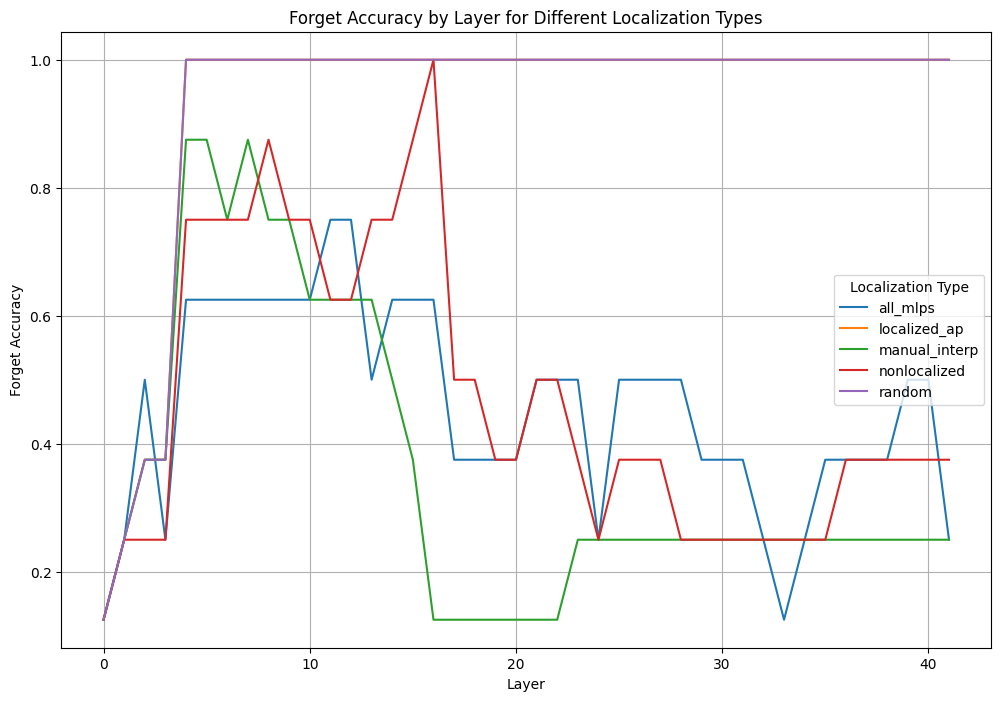

In [6]:
import matplotlib.pyplot as plt

# Group by localization_type and layer, then calculate the mean forget_acc
mean_forget_accs = probe_forget_accs_df.groupby(["localization_type", "layer"])['forget_acc'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 8))
for localization_type in mean_forget_accs.index:
    plt.plot(mean_forget_accs.columns, mean_forget_accs.loc[localization_type], label=localization_type)

plt.xlabel('Layer')
plt.ylabel('Forget Accuracy')
plt.title('Forget Accuracy by Layer for Different Localization Types')
plt.legend(title='Localization Type')
plt.grid(True)
plt.show()

### Plot Relearning

In [7]:
relearning_results_df.query("localization_type == 'manual_interp'")

,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
20,manual_interp,3,0,0.73,0.027034,0.939545,0.061113,0.877707
21,manual_interp,3,1,0.74,0.164881,0.869104,0.122364,0.883581
22,manual_interp,3,2,0.75,0.185483,0.896749,0.122270,0.899815
23,manual_interp,3,3,0.75,0.187656,0.915079,0.121396,0.902787
24,manual_interp,3,4,0.75,0.195173,0.935704,0.121361,0.920377
25,manual_interp,3,5,0.75,0.203656,0.942899,0.126189,0.912497
26,manual_interp,3,6,0.74,0.209819,0.945299,0.135858,0.924150
27,manual_interp,3,7,0.75,0.213249,0.941165,0.145586,0.912344
28,manual_interp,3,8,0.74,0.214939,0.935929,0.149532,0.917058
29,manual_interp,3,9,0.75,0.215093,0.940702,0.150664,0.909528


/tmp/ipykernel_1077110/4174361530.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


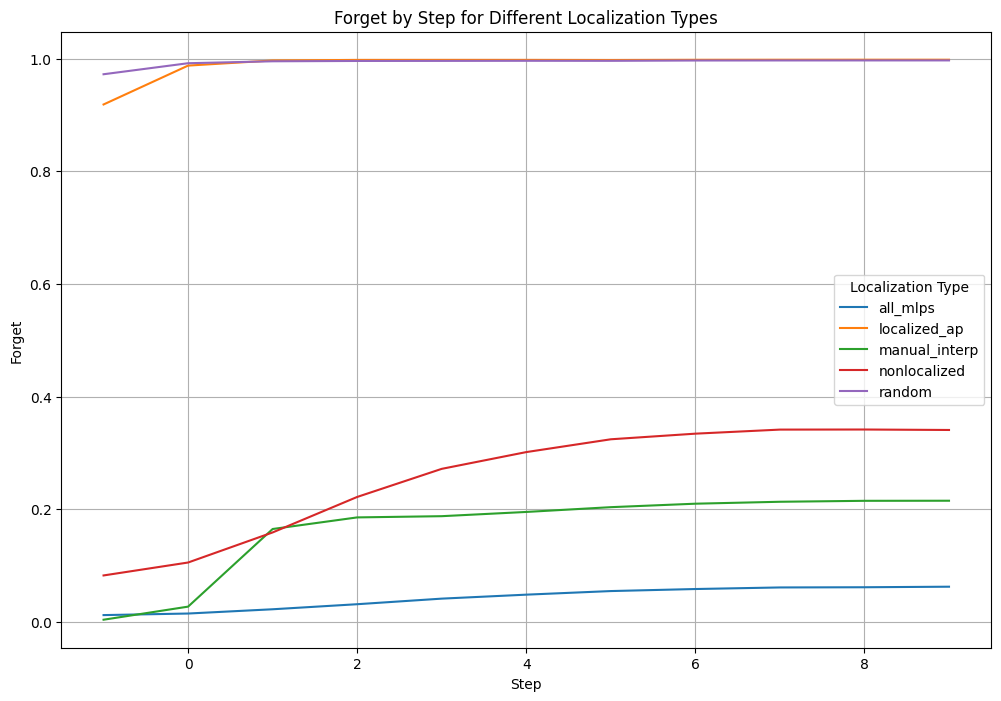

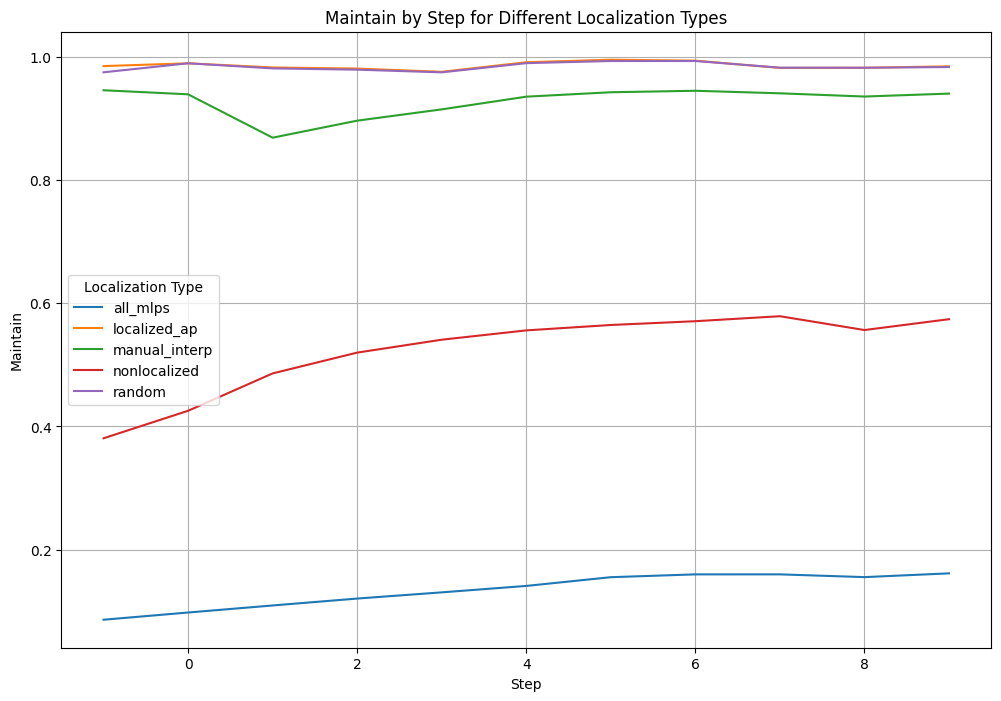

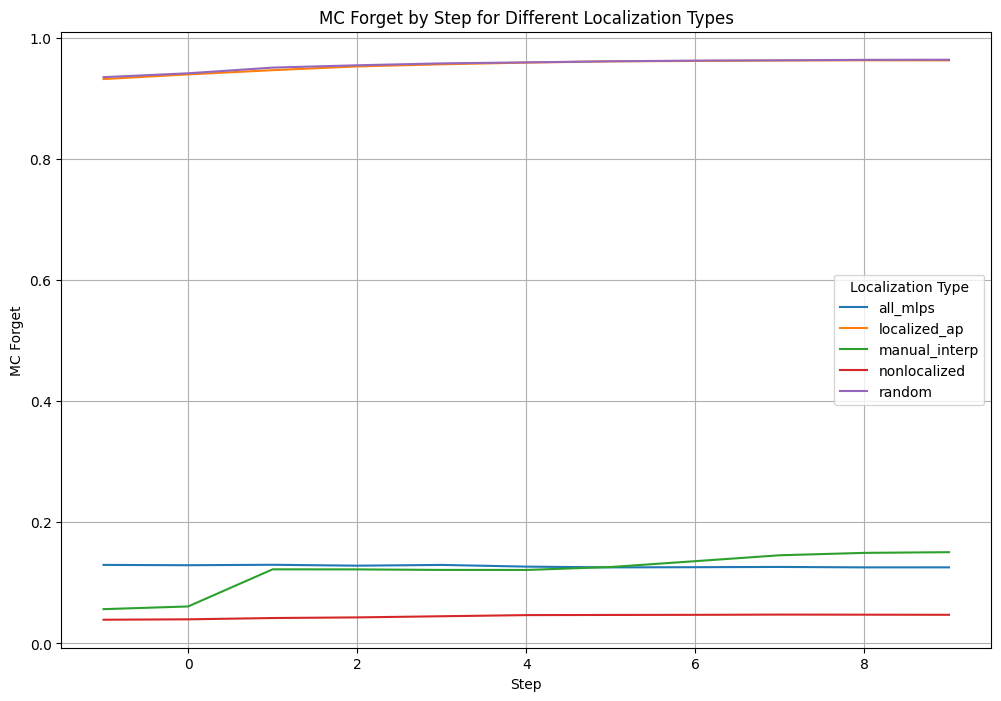

In [8]:
import pandas as pd

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Normal', 'maintain_MC', 'maintain_Normal']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

# Plotting function
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 8))
    for localization_type in mean_metrics['localization_type'].unique():
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        plt.plot(subset['step'], subset[metric], label=localization_type)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} by Step for Different Localization Types')
    plt.legend(title='Localization Type')
    plt.grid(True)
    plt.show()

# Plot forget
plot_metric('forget', 'Forget')

# Plot maintain
plot_metric('maintain', 'Maintain')

# Plot mc_forget
plot_metric('mc_forget', 'MC Forget')

# Plot mc_maintain
# plot_metric('mc_maintain', 'MC Maintain')